In [22]:
import pandas as pd
df = pd.read_csv("./올영_세일.csv", encoding="utf-8")

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("./올영_세일.csv", encoding="utf-8")

def to_num(x):
    if pd.isna(x):
        return None
    x = str(x).replace("원","").replace(",","").replace("~","").strip()
    return int(x) if x.isdigit() else None

df["price_num"] = df["price"].apply(to_num)
df["orig_price_num"] = df["orig_price"].apply(to_num)

df["discount_rate"] = (df["orig_price_num"] - df["price_num"]) / df["orig_price_num"]
df["discount_rate"] = df["discount_rate"].fillna(0)

df["rank"] = df.index + 1

df_model = df[["price_num", "orig_price_num", "discount_rate", "rank"]].dropna()

X = df_model[["price_num", "orig_price_num", "discount_rate"]]
y = df_model["rank"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [24]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:squarederror"
)

xgb.fit(X_train, y_train)
model = xgb  

####  전체 상품에 대해 예측 순위(pred_rank) 생성

In [25]:
df["pred_rank"] = model.predict(X)
df["popularity_score"] = 1 / df["pred_rank"]
df["value_score"] = df["popularity_score"] / df["price_num"]

#### 할인 민감도

In [26]:
def compute_discount_sensitivity(row, model):
    orig_price = row["orig_price_num"]
    base_price = row["price_num"]
    base_rate = row["discount_rate"]

    # 현재 예측값
    base_pred = model.predict([[base_price, orig_price, base_rate]])[0]

    # 할인율 +10%
    new_rate = min(base_rate + 0.1, 0.7)
    new_price = int(orig_price * (1 - new_rate))

    new_pred = model.predict([[new_price, orig_price, new_rate]])[0]

    improvement = base_pred - new_pred
    return max(improvement, 0)  # 음수는 0 처리

In [27]:
import numpy as np

def compute_discount_sensitivity(row, model):

    orig_price = row["orig_price_num"]
    base_price = row["price_num"]
    base_pred = row["pred_rank"]
    base_rate = row["discount_rate"]

    new_rate = min(base_rate + 0.1, 0.7)  
    new_price = int(orig_price * (1 - new_rate))

    X_new = [[new_price, orig_price, new_rate]]
    new_pred = model.predict(X_new)[0]

    improvement = base_pred - new_pred

    return max(improvement, 0)

#### 민감도 계산

In [28]:
df["discount_sensitivity"] = df.apply(
    lambda row: compute_discount_sensitivity(row, model), axis=1
)

#### popularity_boost_score 계산

In [29]:
df["popularity_boost_score"] = (
    df["discount_sensitivity"] - df["discount_sensitivity"].min()
) / (df["discount_sensitivity"].max() - df["discount_sensitivity"].min() + 1e-9)

#### 이미 만든 value_score와 결합

In [30]:
df["hybrid_score"] = df["value_score"] * (1 + df["popularity_boost_score"])

#### 최종 하이브리드 스코어 계산

In [31]:
df["hybrid_score"] = df["value_score"] * (1 + df["popularity_boost_score"])

#### 하이브리드 추천 TOP 30 출력

In [32]:
top_hybrid = df.sort_values("hybrid_score", ascending=False).head(30)
top_hybrid[["name", "price_num", "discount_rate",
            "value_score", "popularity_boost_score",
            "hybrid_score", "url"]]

,name,price_num,discount_rate,value_score,popularity_boost_score,hybrid_score,url
12,딜라이트 프로젝트\n딜라이트 프로젝트 베이글칩 모음전,2500,0.074074,3.238970e-06,0.000000,3.238970e-06,https://www.oliveyoung.co.kr/store/goods/getGo...
380,딜라이트 프로젝트\n딜라이트 프로젝트 베이글칩 8종 택1,2500,0.074074,3.238970e-06,0.000000,3.238970e-06,https://www.oliveyoung.co.kr/store/goods/getGo...
25,딜라이트 프로젝트\n[어워즈특가] 딜라이트 프로젝트 베이글칩 어워즈 한정기획 7종 ...,2500,0.074074,3.238970e-06,0.000000,3.238970e-06,https://www.oliveyoung.co.kr/store/goods/getGo...
51,메디힐\n[14년연속 누적판매 1위] 메디힐 에센셜 마스크팩 1매 고기능 7종 택1,950,0.525000,1.950613e-06,0.000000,1.950613e-06,https://www.oliveyoung.co.kr/store/goods/getGo...
658,좋은느낌\n좋은느낌 오리지널 울트라날개 생리대 9종 택 1 (소형 / 중형 / 대형...,1170,0.350000,1.225072e-06,0.185080,1.451808e-06,https://www.oliveyoung.co.kr/store/goods/getGo...
826,듀이트리\n[밀착진정] 듀이트리 AC 딥 진정 마스크 1매 (열감/흔적),1190,0.603333,1.325794e-06,0.000000,1.325794e-06,https://www.oliveyoung.co.kr/store/goods/getGo...
1072,크리넥스\n[99특가]크리넥스 마이비데 클린케어 4종 택 1 (10매/80매(캡)/...,990,0.292857,1.234725e-06,0.000000,1.234725e-06,https://www.oliveyoung.co.kr/store/goods/getGo...
209,쏘피\n[반값특가]쏘피 바디피트 내몸에 순한면 10종 택 1 (단품/번들),1330,0.300000,1.216664e-06,0.000000,1.216664e-06,https://www.oliveyoung.co.kr/store/goods/getGo...
648,케어플러스\n[99특가/1+1] 케어플러스 아랫배 찜질 패드 1매입,990,0.175000,1.148827e-06,0.000000,1.148827e-06,https://www.oliveyoung.co.kr/store/goods/getGo...
1159,케어플러스\n[99특가/1+1]케어플러스 아랫배 찜질 패드 1매입/5매입,990,0.175000,1.148827e-06,0.000000,1.148827e-06,https://www.oliveyoung.co.kr/store/goods/getGo...


In [33]:
df["brand"] = df["name"].apply(lambda x: str(x).split("\n")[0].split()[0])

#### 브랜드별 평균 하이브리드 스코어 계산

In [ ]:
brand_score = (
    df.groupby("brand")["hybrid_score"]
      .mean()
      .sort_values(ascending=False)
)

brand_score.head(30)

#### 브랜드별 하이브리드 스코어 상위 30개 시각화 (Bar Plot)

In [34]:
brand_score = (
    df.groupby("brand")["hybrid_score"]
      .mean()
      .sort_values(ascending=False)
)

brand_score.head(30)

brand
크리넥스       1.234725e-06
딜라이트       1.009998e-06
비브리브       8.664775e-07
밀잇         8.352590e-07
크런틴        8.352590e-07
쏘피         7.692011e-07
좋은느낌       5.623591e-07
도브         5.416850e-07
케어플러스      4.928684e-07
올리브영       4.881239e-07
순수한면       4.614619e-07
인클리어       4.270310e-07
멕리듬        3.869251e-07
더마팩토리      3.798377e-07
포레스트스토리    3.603269e-07
테일러        3.589666e-07
스너글        3.560276e-07
더블유드레스룸    3.546744e-07
듀이트리       3.469936e-07
메디힐        3.336637e-07
바티스트       3.316354e-07
레노아        3.206609e-07
홀리카홀리카     3.170238e-07
티젠         3.110999e-07
필리밀리       3.060098e-07
아임미미       3.048049e-07
페리페라       2.927001e-07
시루콧토       2.869394e-07
라엘         2.854712e-07
가그린        2.763241e-07
Name: hybrid_score, dtype: float64

#### 브랜드별 하이브리드 스코어 상위 30개 시각화 (Bar Plot)

In [36]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = "/System/Library/Fonts/AppleSDGothicNeo.ttc"
fontprop = fm.FontProperties(fname=font_path)

plt.rcParams["font.family"] = fontprop.get_name()
plt.rcParams["axes.unicode_minus"] = False

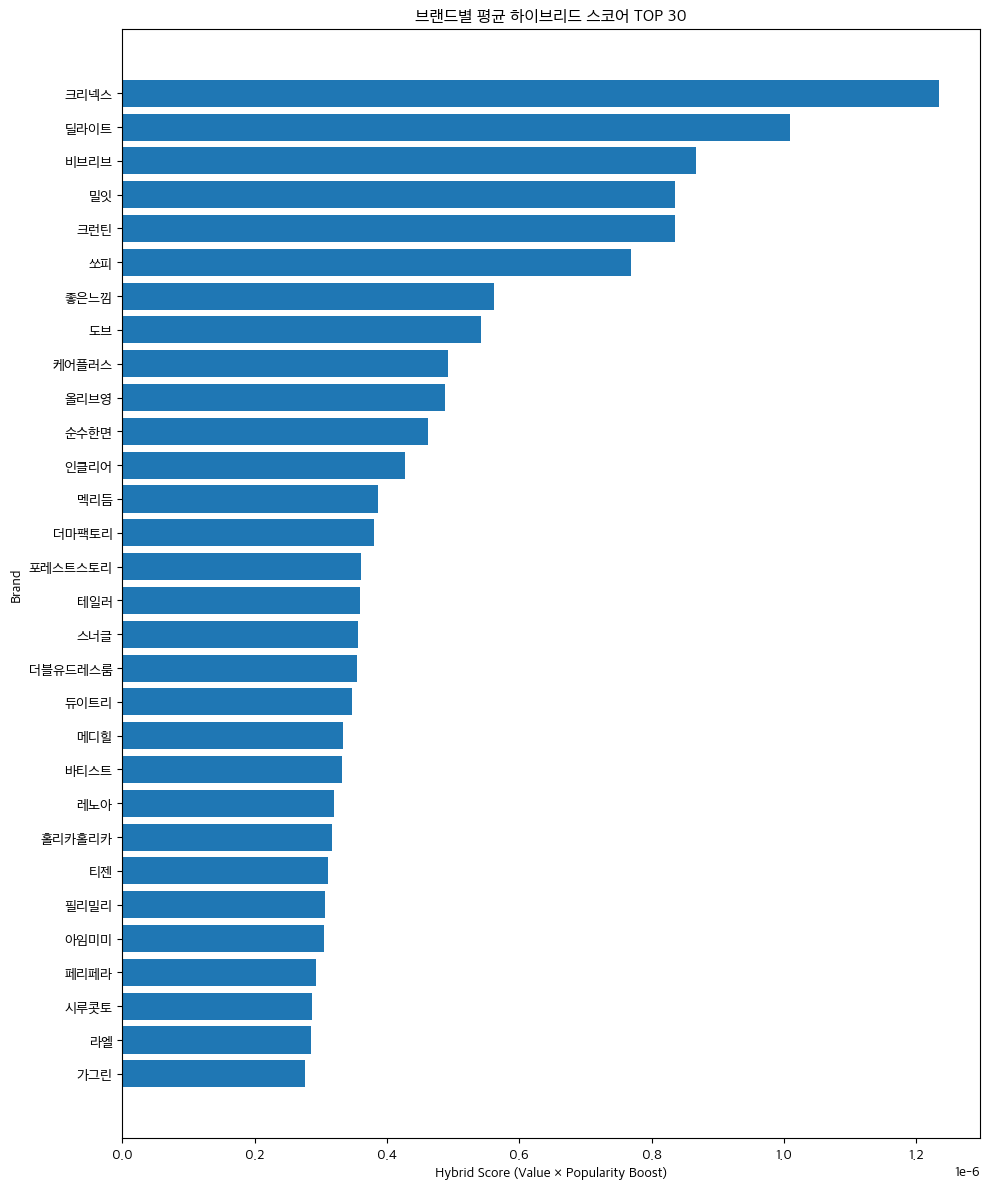

In [37]:
import matplotlib.pyplot as plt

top30 = brand_score.head(30)

plt.figure(figsize=(10, 12))
plt.barh(top30.index[::-1], top30.values[::-1])
plt.title("브랜드별 평균 하이브리드 스코어 TOP 30")
plt.xlabel("Hybrid Score (Value × Popularity Boost)")
plt.ylabel("Brand")
plt.tight_layout()
plt.show()

In [ ]:
# 📌 해석 포인트


# ✔ 가격대가 적당하고

# ✔ 할인율이 좋고

# ✔ 할인 증가 시 인기 상승폭이 큰 브랜드

# 이 전반적으로 가장 높은 가치를 주는 브랜드로 랭킹됨.